In [1]:
import os, re, glob, random, math, json, gc, pathlib, sys
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("TF:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TF: 2.18.0
GPU available: False


# Data Split

In [23]:
# === Stratified split into dev(train/val) and test, with Windows paths ===
import os, re, shutil, random
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --------------------
# INPUTS 
# --------------------
DATA_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\DataSet_CdTe"      
OUT_ROOT = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe"        
TEST_RATIO = 0.20                       #  0.20 → 80/20 dev/test
VAL_RATIO_WITHIN_DEV = 0.20             #  0.20 of dev → dev/val (so train is 0.80 of dev)
RECURSIVE = False                       
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# --------------------
# Label rules
# --------------------
def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^Twin_Bound",        base, flags=re.IGNORECASE): return "TB"
    if re.match(r"^interstitial",         base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Vacancy_CdTe",           base, flags=re.IGNORECASE): return "Vac"
    if re.match(r"^LC",           base, flags=re.IGNORECASE): return "LC"
    if re.match(r"^SF1",           base, flags=re.IGNORECASE): return "SF1"
    if re.match(r"^SF2",           base, flags=re.IGNORECASE): return "SF2"
    return None


p = Path(DATA_DIR)
exts = ("*.tif","*.tiff","*.TIF","*.TIFF")
hits = []
if RECURSIVE:
    for ext in exts:
        hits += list(p.rglob(ext))
else:
    for ext in exts:
        hits += list(p.glob(ext))

# Deduplicate by filename (case-insensitive)
hits = [q for q in hits if q.is_file()]
hits = sorted(hits, key=lambda q: q.name.lower())
seen = set(); files = []
for q in hits:
    key = q.name.lower()
    if key not in seen:
        seen.add(key)
        files.append(q)

print(f"Total unique TIFF files found: {len(files)}")

# Build dataframe with labels
df = pd.DataFrame({
    "path": [str(f) for f in files],
    "name": [f.name for f in files],
})
df["label"] = df["name"].apply(infer_label_from_name)

# Separate labeled vs unlabeled (None)
df_lab   = df[df["label"].notna()].copy()
df_unlab = df[df["label"].isna()].copy()
print("Labeled:", len(df_lab), "Unlabeled:", len(df_unlab))
print("Labeled class counts:\n", df_lab["label"].value_counts())

# --------------------
# 1) Split labeled data into DEV and TEST 
# --------------------
if len(df_lab) > 0:
    dev_lab, test_lab = train_test_split(
        df_lab, test_size=TEST_RATIO, random_state=SEED, stratify=df_lab["label"]
    )
else:
    dev_lab, test_lab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

# 2) Split unlabeled data into DEV and TEST 
if len(df_unlab) > 0:
    test_unlab = df_unlab.sample(frac=TEST_RATIO, random_state=SEED)
    dev_unlab  = df_unlab.drop(test_unlab.index)
else:
    dev_unlab, test_unlab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

dev_df  = pd.concat([dev_lab, dev_unlab], ignore_index=True)
test_df = pd.concat([test_lab, test_unlab], ignore_index=True)

print(f"\nDEV total: {len(dev_df)}  (labeled={len(dev_lab)}, unlabeled={len(dev_unlab)})")
print(f"TEST total: {len(test_df)} (labeled={len(test_lab)}, unlabeled={len(test_unlab)})")
if len(dev_lab):
    print("DEV labeled class counts:\n", dev_lab["label"].value_counts())
if len(test_lab):
    print("TEST labeled class counts:\n", test_lab["label"].value_counts())

# --------------------
# 3) Inside DEV: split into TRAIN and VAL 
# --------------------
if len(dev_lab) > 0:
    train_lab, val_lab = train_test_split(
        dev_lab, test_size=VAL_RATIO_WITHIN_DEV, random_state=SEED, stratify=dev_lab["label"]
    )
else:
    train_lab, val_lab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

# Unlabeled portion
if len(dev_unlab) > 0:
    val_unlab = dev_unlab.sample(frac=VAL_RATIO_WITHIN_DEV, random_state=SEED)
    train_unlab = dev_unlab.drop(val_unlab.index)
else:
    train_unlab, val_unlab = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

train_df = pd.concat([train_lab, train_unlab], ignore_index=True)
val_df   = pd.concat([val_lab,   val_unlab],   ignore_index=True)

print(f"\nTRAIN total: {len(train_df)}  (labeled={len(train_lab)}, unlabeled={len(train_unlab)})")
print(f"VAL   total: {len(val_df)}    (labeled={len(val_lab)},   unlabeled={len(val_unlab)})")
if len(train_lab):
    print("TRAIN labeled class counts:\n", train_lab["label"].value_counts())
if len(val_lab):
    print("VAL labeled class counts:\n", val_lab["label"].value_counts())

# --------------------
# 4) Create folders and COPY files
# --------------------
dev_train_dir = Path(OUT_ROOT) / "dev_CdTe" / "train"
dev_val_dir   = Path(OUT_ROOT) / "dev_CdTe" / "val"
test_dir      = Path(OUT_ROOT) / "test_CdTe"
for d in [dev_train_dir, dev_val_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)

def _copy_rows(rows, dst_dir: Path):
    for src in rows["path"].tolist():
        dst = dst_dir / Path(src).name
        if not dst.exists():
            shutil.copy2(src, dst)

_copy_rows(train_df, dev_train_dir)
_copy_rows(val_df,   dev_val_dir)
_copy_rows(test_df,  test_dir)

print("\nDone.")
print(f"Copied → {dev_train_dir}  : {len(list(dev_train_dir.glob('*')))} files")
print(f"Copied → {dev_val_dir}    : {len(list(dev_val_dir.glob('*')))} files")
print(f"Copied → {test_dir}       : {len(list(test_dir.glob('*')))} files")

Total unique TIFF files found: 1319
Labeled: 1319 Unlabeled: 0
Labeled class counts:
 label
Bulk    385
LC      183
SF1     181
Vac     174
Int     155
SF2     132
TB      109
Name: count, dtype: int64

DEV total: 1055  (labeled=1055, unlabeled=0)
TEST total: 264 (labeled=264, unlabeled=0)
DEV labeled class counts:
 label
Bulk    308
LC      146
SF1     145
Vac     139
Int     124
SF2     106
TB       87
Name: count, dtype: int64
TEST labeled class counts:
 label
Bulk    77
LC      37
SF1     36
Vac     35
Int     31
SF2     26
TB      22
Name: count, dtype: int64

TRAIN total: 844  (labeled=844, unlabeled=0)
VAL   total: 211    (labeled=211,   unlabeled=0)
TRAIN labeled class counts:
 label
Bulk    246
LC      117
SF1     116
Vac     111
Int      99
SF2      85
TB       70
Name: count, dtype: int64
VAL labeled class counts:
 label
Bulk    62
SF1     29
LC      29
Vac     28
Int     25
SF2     21
TB      17
Name: count, dtype: int64

Done.
Copied → C:\Users\rayyub2\Desktop\Ayyubi\Hacka

# Training

In [24]:
import os, re, numpy as np, tensorflow as tf
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TerminateOnNaN
from PIL import Image

# -------- PATHS from your split --------
ROOT          = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe"
DEV_TRAIN_DIR = rf"{ROOT}\dev_CdTe\train"
DEV_VAL_DIR   = rf"{ROOT}\dev_CdTe\val"
TEST_DIR      = rf"{ROOT}\test_CdTe"   

# -------- Global config --------
SEED = 42
IMG_H, IMG_W = 64, 64
RESIZE_H, RESIZE_W = 224, 224
BATCH_SIZE = 16
tf.random.set_seed(SEED); np.random.seed(SEED)

# -------- Helpers --------
def list_unique_top_level_tiffs(folder):
    p = Path(folder)
    hits = []
    for ext in ("*.tif","*.tiff","*.TIF","*.TIFF"):
        hits += list(p.glob(ext))
    hits = [q for q in hits if q.is_file()]
    hits = sorted(hits, key=lambda x: x.name.lower())
    seen=set(); out=[]
    for q in hits:
        k = q.name.lower()
        if k not in seen:
            seen.add(k); out.append(str(q))
    return out

def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^Twin_Bound",        base, flags=re.IGNORECASE): return "TB"
    if re.match(r"^interstitial",         base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Vacancy_CdTe",           base, flags=re.IGNORECASE): return "Vac"
    if re.match(r"^LC",           base, flags=re.IGNORECASE): return "LC"
    if re.match(r"^SF1",           base, flags=re.IGNORECASE): return "SF1"
    if re.match(r"^SF2",           base, flags=re.IGNORECASE): return "SF2"
    return None

def load_grayscale_64(path):
    img = Image.open(path).convert("L").resize((IMG_W, IMG_H))
    arr = np.array(img, dtype=np.float32)
    if arr.max() > 1.0: arr = arr/255.0
    return arr

from tensorflow.keras.applications.vgg16 import preprocess_input
def preprocess_for_vgg(x):   # x: [64,64,1] float in [0,1]
    x = tf.image.resize(x, (RESIZE_H, RESIZE_W))
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x*255.0)
    return x

# -------- Load DEV train/val as arrays --------
train_files = list_unique_top_level_tiffs(DEV_TRAIN_DIR)
val_files   = list_unique_top_level_tiffs(DEV_VAL_DIR)

Xtr = np.expand_dims(np.stack([load_grayscale_64(f) for f in train_files], axis=0), axis=-1)  # [Ntr,64,64,1]
Xva = np.expand_dims(np.stack([load_grayscale_64(f) for f in val_files],   axis=0), axis=-1)  # [Nva,64,64,1]

ytr_names = [infer_label_from_name(Path(f).name) for f in train_files]
yva_names = [infer_label_from_name(Path(f).name) for f in val_files]

# Encode labels (fit on DEV all classes)
le = LabelEncoder()
le.fit([n for n in (ytr_names+yva_names) if n is not None])

# filter out any None (unlabeled) to keep supervision clean
tr_keep = [i for i,y in enumerate(ytr_names) if y is not None]
va_keep = [i for i,y in enumerate(yva_names) if y is not None]

Xtr = Xtr[tr_keep]
Xva = Xva[va_keep]
ytr = le.transform([ytr_names[i] for i in tr_keep])
yva = le.transform([yva_names[i] for i in va_keep])

num_classes = len(le.classes_)
print("Classes:", list(le.classes_), "num_classes=", num_classes)
print("Train class counts:", Counter(ytr))
print("Val   class counts:", Counter(yva))

# Class weights (balanced)
cls_weights = compute_class_weight(class_weight="balanced", classes=np.unique(ytr), y=ytr)
class_weights = {int(c): float(w) for c,w in zip(np.unique(ytr), cls_weights)}
print("Class weights:", class_weights)

# ---------- tf.data pipelines ----------
AUTOTUNE = tf.data.AUTOTUNE
def ds_from_numpy(imgs, ys, shuffle=False, aug=False, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    def _map(x,y):
        x = preprocess_for_vgg(x)
        if aug:
            k = tf.random.uniform([], 0, 4, dtype=tf.int32)
            x = tf.image.rot90(x, k)
            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
        return x,y
    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

dtr = ds_from_numpy(Xtr, ytr, shuffle=True,  aug=True)
dva = ds_from_numpy(Xva, yva, shuffle=False, aug=False)

# ---------- Manual label smoothing ----------
def sparse_ce_with_smoothing(num_classes, epsilon=0.05):
    cce = tf.keras.losses.CategoricalCrossentropy()
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_one  = tf.one_hot(y_true, depth=num_classes)
        y_smooth = (1.0 - epsilon)*y_one + epsilon/float(num_classes)
        return cce(y_smooth, y_pred)
    return loss_fn

# ---------- Model: VGG16 + head ----------
inp  = layers.Input(shape=(RESIZE_H, RESIZE_W, 3))
base = VGG16(include_top=False, weights="imagenet", input_tensor=inp, pooling="avg")
base.trainable = False

x = layers.Dropout(0.4)(base.output)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(num_classes, activation="softmax")(x)
clf = models.Model(inp, out)

# ---------- Callbacks ----------
CKPT_DIR = os.path.join(ROOT, "_CdTe_vgg16_ckpts"); os.makedirs(CKPT_DIR, exist_ok=True)

def cbs(stage_name, monitor="val_loss", mode="min", min_delta=5e-4, patience=7):
    return [
        EarlyStopping(
            monitor=monitor,
            mode=mode,
            patience=patience,
            min_delta=min_delta,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor=monitor,
            mode=mode,
            factor=0.5,
            patience=max(2, patience//2),
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(CKPT_DIR, f"{stage_name}_best.keras"),
            monitor=monitor,
            mode=mode,
            save_best_only=True,
            verbose=1
        ),
        TerminateOnNaN()
    ]

hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

# ---------- Stage 1: Warmup ----------
clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.05),
            metrics=["accuracy"])
h1 = clf.fit(
    dtr, validation_data=dva, epochs=30,
    callbacks=cbs("warmup"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h1.history.get("accuracy", [])
hist_val_acc += h1.history.get("val_accuracy", [])
hist_loss    += h1.history.get("loss", [])
hist_val_loss+= h1.history.get("val_loss", [])

# ---------- Stage 2: Unfreeze block5* ----------
for layer in base.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True
clf.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.05),
            metrics=["accuracy"])
h2 = clf.fit(
    dtr, validation_data=dva, epochs=30,
    callbacks=cbs("finetune_block5"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h2.history.get("accuracy", [])
hist_val_acc += h2.history.get("val_accuracy", [])
hist_loss    += h2.history.get("loss", [])
hist_val_loss+= h2.history.get("val_loss", [])

# ---------- Stage 3: Unfreeze block4*+block5*  ----------
for layer in base.layers:
    if layer.name.startswith(("block4","block5")):
        layer.trainable = True
clf.compile(optimizer=tf.keras.optimizers.Adam(1.5e-6),
            loss=sparse_ce_with_smoothing(num_classes, epsilon=0.03),
            metrics=["accuracy"])
h3 = clf.fit(
    dtr, validation_data=dva, epochs=40,
    callbacks=cbs("finetune_block45"),
    class_weight=class_weights, verbose=1
)
hist_acc     += h3.history.get("accuracy", [])
hist_val_acc += h3.history.get("val_accuracy", [])
hist_loss    += h3.history.get("loss", [])
hist_val_loss+= h3.history.get("val_loss", [])

# ---------- Validation evaluation ----------
va_loss, va_acc = clf.evaluate(dva, verbose=0)
print(f"\nValidation accuracy (best weights): {va_acc:.3f} | val_loss={va_loss:.4f}")

# ---------- Save val predictions for confusion matrix  ----------
# Build a val dataset again (no aug, same mapping)
def ds_val_only(imgs, ys, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    ds = ds.map(lambda x,y: (preprocess_for_vgg(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

dva_plain = ds_val_only(Xva, yva)
val_probs = clf.predict(dva_plain, verbose=0)
pred = np.argmax(val_probs, axis=1) 
Yva  = yva                          

print("\nRunning frozen-embedding logistic regression baseline...")
frozen = VGG16(include_top=False, weights="imagenet",
               input_shape=(RESIZE_H,RESIZE_W,3), pooling='avg')
frozen.trainable = False

def ds_plain(imgs, ys, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((imgs, ys))
    ds = ds.map(lambda x,y: (preprocess_for_vgg(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

def embed(ds):
    E, Y = [], []
    for xb, yb in ds:
        E.append(frozen.predict(xb, verbose=0))
        Y.append(yb.numpy())
    return np.vstack(E), np.concatenate(Y)

Etr, Ytr = embed(ds_plain(Xtr, ytr))
Eva, Yva_baseline = embed(ds_plain(Xva, yva))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Etr, Ytr)
val_pred = lr.predict(Eva)
print("Frozen-embedding logistic-reg VAL acc:", accuracy_score(Yva_baseline, val_pred))

# Keep histories for next plotting cell
hist_acc, hist_val_acc, hist_loss, hist_val_loss = list(hist_acc), list(hist_val_acc), list(hist_loss), list(hist_val_loss)


Classes: ['Bulk', 'Int', 'LC', 'SF1', 'SF2', 'TB', 'Vac'] num_classes= 7
Train class counts: Counter({0: 246, 2: 117, 3: 116, 6: 111, 1: 99, 4: 85, 5: 70})
Val   class counts: Counter({0: 62, 2: 29, 3: 29, 6: 28, 1: 25, 4: 21, 5: 17})
Class weights: {0: 0.4901277584204414, 1: 1.2178932178932178, 2: 1.0305250305250304, 3: 1.0394088669950738, 4: 1.4184873949579833, 5: 1.7224489795918367, 6: 1.0862290862290862}
Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.2337 - loss: 3.5304
Epoch 1: val_loss improved from inf to 1.03092, saving model to C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\_CdTe_vgg16_ckpts\warmup_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2347 - loss: 3.5183 - val_accuracy: 0.7393 - val_loss: 1.0309 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.4614 - loss: 1.7769
Epoch 2: val_loss improved from 1.03092 to 0.98239, saving model to C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\_

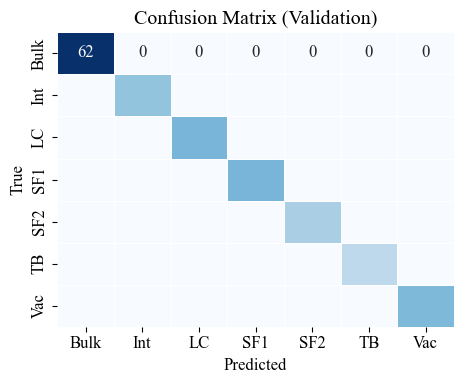

              precision    recall  f1-score   support

        Bulk       1.00      1.00      1.00        62
         Int       1.00      1.00      1.00        25
          LC       1.00      1.00      1.00        29
         SF1       1.00      1.00      1.00        29
         SF2       1.00      1.00      1.00        21
          TB       1.00      1.00      1.00        17
         Vac       1.00      1.00      1.00        28

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



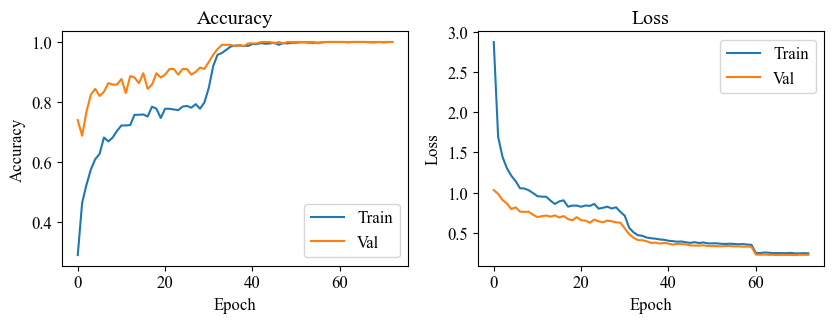

In [25]:
# === Plot Confusion Matrix + Training Curves
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

# ---- Global style ----
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

FIGSIZE_CM   = (4.8, 4.0)   # Confusion Matrix
FIGSIZE_CURV = (8.5, 3.4)   # Training Curves

SAVE_CONFUSION_PATH = rf"{ROOT}\confusion_matrix.png"
SAVE_CURVES_PATH    = rf"{ROOT}\training_curves.png"

DPI_EXPORT   = 800
PAD_INCHES   = 0.03

def _save_current_figure(path, dpi=DPI_EXPORT, pad_inches=PAD_INCHES):
    if path is not None:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=pad_inches)
try:
    _ = (Yva, pred, le)
    cm = confusion_matrix(Yva, pred, labels=np.arange(len(le.classes_)))
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(le.classes_), yticklabels=list(le.classes_),
                cbar=False, linewidths=0.5, linecolor='white')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Validation)")
    plt.tight_layout()
    _save_current_figure(SAVE_CONFUSION_PATH)
    plt.show()

    print(classification_report(Yva, pred, target_names=list(le.classes_)))
except NameError:
    print("Yva/pred/le missing → run the training cell first.")

try:
    _ = (hist_acc, hist_val_acc, hist_loss, hist_val_loss)
    plt.figure(figsize=FIGSIZE_CURV)

    plt.subplot(1, 2, 1)
    plt.plot(hist_acc, label="Train")
    plt.plot(hist_val_acc, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(frameon=True)

    plt.subplot(1, 2, 2)
    plt.plot(hist_loss, label="Train")
    plt.plot(hist_val_loss, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(frameon=True)

    plt.tight_layout()
    _save_current_figure(SAVE_CURVES_PATH)
    plt.show()
except NameError:
    print("Training histories missing → run the training cell first.")


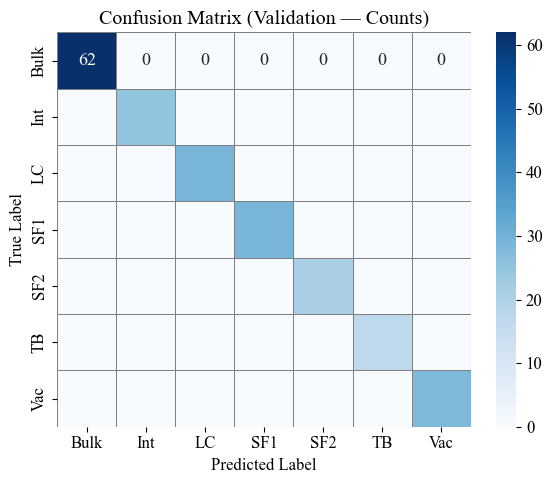

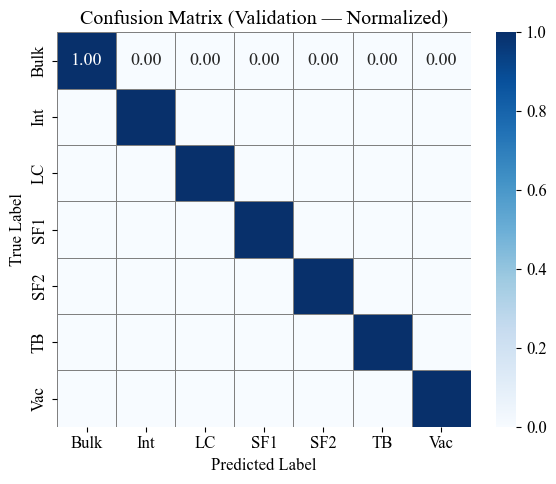


Classification Report (Validation):

              precision    recall  f1-score   support

        Bulk       1.00      1.00      1.00        62
         Int       1.00      1.00      1.00        25
          LC       1.00      1.00      1.00        29
         SF1       1.00      1.00      1.00        29
         SF2       1.00      1.00      1.00        21
          TB       1.00      1.00      1.00        17
         Vac       1.00      1.00      1.00        28

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



In [26]:
# ============================================================
# Confusion Matrix (Validation)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

assert "Yva" in globals(), "Yva not found — run training cell first"
assert "pred" in globals(), "pred not found — run prediction cell first"
assert "le"   in globals(), "LabelEncoder not found"

class_names = list(le.classes_)

cm_counts = confusion_matrix(Yva, pred, labels=np.arange(len(class_names)))
cm_norm   = confusion_matrix(
    Yva, pred,
    labels=np.arange(len(class_names)),
    normalize="true"
)
# ============================================================
# Plot 1: RAW COUNTS
# ============================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_counts,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="gray",
    cbar=True,
    annot_kws={"size": 13}
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation — Counts)")
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: NORMALIZED 
# ============================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="gray",
    cbar=True,
    vmin=0.0,
    vmax=1.0,
    annot_kws={"size": 13}
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation — Normalized)")
plt.tight_layout()
plt.show()

print("\nClassification Report (Validation):\n")
print(classification_report(Yva, pred, target_names=class_names))


In [71]:
# === Extract embeddings from the trained classifier (penultimate GAP) ===
import numpy as np, tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64
RESIZE_H = RESIZE_W = 224

# Reuse preprocess_for_vgg defined earlier
def make_infer_ds(images_64, batch=BATCH):
    ds = tf.data.Dataset.from_tensor_slices(images_64)
    ds = ds.map(lambda x: preprocess_for_vgg(x), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

# DEV embeddings = train+val
Xdev = np.concatenate([Xtr, Xva], axis=0)
dev_files = [*train_files, *val_files]

infer_ds_dev = make_infer_ds(Xdev)

# TEST set → load now as arrays
from PIL import Image
def load_grayscale_64(path):
    img = Image.open(path).convert("L").resize((64,64))
    arr = np.array(img, dtype=np.float32)
    if arr.max()>1.0: arr/=255.0
    return arr

test_files = [str(p) for p in Path(TEST_DIR).glob("*.tif")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.tiff")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.TIF")] \
           + [str(p) for p in Path(TEST_DIR).glob("*.TIFF")]
# dedup by name
test_files = sorted(list({Path(f).name.lower(): f for f in test_files}.values()))

Xtest = np.expand_dims(np.stack([load_grayscale_64(f) for f in test_files], axis=0), axis=-1)
infer_ds_test = make_infer_ds(Xtest)

# Build embedder from trained clf (GAP layer)
gap_layer = [L for L in clf.layers if isinstance(L, layers.GlobalAveragePooling2D)][-1]
embedder = tf.keras.Model(inputs=clf.input, outputs=gap_layer.output)  # (None, 512)

# Compute embeddings
emb_dev  = np.vstack([embedder.predict(xb, verbose=0) for xb in infer_ds_dev]).astype(np.float32)
emb_test = np.vstack([embedder.predict(xb, verbose=0) for xb in infer_ds_test]).astype(np.float32)
print("Embeddings DEV :", emb_dev.shape)
print("Embeddings TEST:", emb_test.shape)

# Keep filenames for later
filenames_dev  = dev_files
filenames_test = test_files


Embeddings DEV : (1055, 512)
Embeddings TEST: (264, 512)


C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:13


🏆 Top-5 (p, k) candidates by silhouette score:

   pca_dim  k  silhouette
0        2  3    0.728429
1        6  7    0.713727
2        6  8    0.696437
3        5  6    0.688663
4        4  5    0.666731

💾 Saved: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs\top5_pca_k_candidates_silhouette.csv


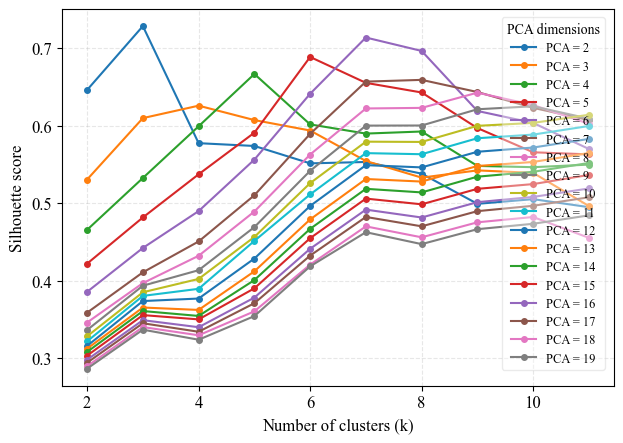

✔ Saved silhouette plot: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs\silhouette_vs_k_all_pca.png


In [101]:
# =========================================================
# CELL A: SILHOUETTE GRID SEARCH + TOP-5 SHORTLIST
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

assert "emb_dev" in globals(), "emb_dev not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 100
pca_range = range(2, 20)
k_range   = range(2, 12)
TOP_N = 5

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

scaler = StandardScaler()
Z_dev = scaler.fit_transform(emb_dev)

records = []

for p in pca_range:
    Zp = PCA(n_components=p, random_state=SEED).fit_transform(Z_dev)
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
        labels = km.fit_predict(Zp)

        sil = silhouette_score(Zp, labels)

        records.append({
            "pca_dim": p,
            "k": k,
            "silhouette": sil
        })

df_scores = pd.DataFrame(records)

# -------------------------
# TOP-5 BY SILHOUETTE
# -------------------------
best_candidates = (
    df_scores
    .sort_values("silhouette", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

print("\n🏆 Top-5 (p, k) candidates by silhouette score:\n")
print(best_candidates[["pca_dim", "k", "silhouette"]])

# Save shortlist
csv_path = os.path.join(OUT_DIR, "top5_pca_k_candidates_silhouette.csv")
best_candidates.to_csv(csv_path, index=False)
print(f"\n💾 Saved: {csv_path}")

# -------------------------
# PLOT: Silhouette vs k for ALL PCA dimensions
# -------------------------
sil_by_p = defaultdict(list)
for _, r in df_scores.iterrows():
    sil_by_p[int(r["pca_dim"])].append((int(r["k"]), float(r["silhouette"])))

fig, ax = plt.subplots(figsize=(6.4, 4.6))

for p in sorted(sil_by_p.keys()):
    ks, ss = zip(*sorted(sil_by_p[p], key=lambda t: t[0]))
    ax.plot(
        ks, ss,
        marker="o",
        linewidth=1.5,
        markersize=4,
        label=f"PCA = {p}"
    )

ax.set_xlabel("Number of clusters (k)")
ax.set_ylabel("Silhouette score")
ax.grid(True, linestyle="--", alpha=0.3)

legend = ax.legend(
    title="PCA dimensions",
    loc="upper right",
    bbox_to_anchor=(0.995, 0.995),
    fontsize=9,
    title_fontsize=10,
    frameon=True
)
legend.get_frame().set_alpha(0.4)

# Save plot
fig_path = os.path.join(OUT_DIR, "silhouette_vs_k_all_pca.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=DPI, bbox_inches="tight", pad_inches=PAD)
plt.show()
plt.close()

print(f"✔ Saved silhouette plot: {fig_path}")


In [133]:
# =========================================================
# PCA + KMEANS FOR SELECTED RANK
# =========================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

RANK_IDX = 1   # 0=best, 1=2nd best, ..., 4=5th best

p_sel = int(best_candidates.loc[RANK_IDX, "pca_dim"])
k_sel = int(best_candidates.loc[RANK_IDX, "k"])

print(f"✔ Using rank {RANK_IDX+1}: PCA={p_sel}, k={k_sel}")

scaler = StandardScaler()
Z_dev  = scaler.fit_transform(emb_dev)
Z_test = scaler.transform(emb_test)

pca_model = PCA(n_components=p_sel, random_state=SEED)
Zp_dev  = pca_model.fit_transform(Z_dev)
Zp_test = pca_model.transform(Z_test)

km = KMeans(n_clusters=k_sel, n_init=20, random_state=SEED)
labels_dev = km.fit_predict(Zp_dev)
labels_test_km = km.predict(Zp_test)

best_p = p_sel
best_k = k_sel

print("Unique TEST labels:", np.unique(labels_test_km))


✔ Using rank 2: PCA=6, k=7


C:\Users\rayyub2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Unique TEST labels: [0 1 2 3 4 5 6]


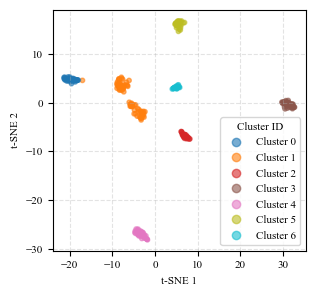

✔ Saved: tsne_rank2_pca6_k7.png


In [134]:
# =========================================================
# CELL C: t-SNE VISUALIZATION (RANK-AWARE)
# =========================================================
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 8

# -------------------------
# t-SNE
# -------------------------
Z_tsne = TSNE(
    n_components=2,
    random_state=SEED,
    init="random",
    perplexity=min(30, len(Zp_test)-1),
    learning_rate="auto"
).fit_transform(Zp_test)

# -------------------------
# PLOT
# -------------------------
fig, ax = plt.subplots(figsize=(3.2, 3))

sc = ax.scatter(
    Z_tsne[:, 0],
    Z_tsne[:, 1],
    c=labels_test_km,
    s=10,
    alpha=0.6,
    cmap="tab10"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.grid(True, linestyle="--", alpha=0.35)

handles, _ = sc.legend_elements(prop="colors")
ax.legend(
    handles,
    [f"Cluster {i}" for i in range(best_k)],
    title="Cluster ID",
    fontsize=8,
    frameon=True
)

fname = f"tsne_rank{RANK_IDX+1}_pca{best_p}_k{best_k}.png"
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, fname), dpi=600, bbox_inches="tight")
plt.show()
plt.close()

print(f"✔ Saved: {fname}")


In [136]:
# =========================================================
#  Build df_features (TEST) & compute clustering purity
# =========================================================

import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

required = ["Zp_test", "labels_test_km", "best_p", "best_k", "filenames_test"]
for r in required:
    assert r in globals(), f"{r} not found — run clustering cell first"

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 12

def infer_label_from_name(name: str):
    base = Path(name).stem
    if re.match(r"^Bulk", base, flags=re.IGNORECASE): return "Bulk"
    if re.match(r"^Twin_Bound", base, flags=re.IGNORECASE): return "TB"
    if re.match(r"^interstitial", base, flags=re.IGNORECASE): return "Int"
    if re.match(r"^Vacancy_CdTe", base, flags=re.IGNORECASE): return "Vac"
    if re.match(r"^LC", base, flags=re.IGNORECASE): return "LC"
    if re.match(r"^SF1", base, flags=re.IGNORECASE): return "SF1"
    if re.match(r"^SF2", base, flags=re.IGNORECASE): return "SF2"
    return None

types_test = [infer_label_from_name(Path(f).name) for f in filenames_test]

pca_cols = [f"PCA_{i+1}" for i in range(best_p)]
df_features = pd.DataFrame(Zp_test, columns=pca_cols)

df_features["Cluster"]  = labels_test_km
df_features["Filename"] = filenames_test
df_features["Type"]     = types_test

cluster_accuracies = []
cluster_sizes = []

print("\n[TEST] Cluster Accuracy Details:\n")

for c in range(best_k):
    cdf = df_features[df_features["Cluster"] == c]
    cluster_sizes.append(len(cdf))

    if cdf.empty:
        cluster_accuracies.append(0.0)
        print(f"Cluster {c}: EMPTY\n")
        continue

    valid = cdf["Type"].dropna()

    if valid.empty:
        acc = 0.0
        counts = {}
        major = None
    else:
        counts = valid.value_counts().to_dict()
        major  = valid.mode()[0]
        acc    = 100.0 * counts.get(major, 0) / len(cdf)

    cluster_accuracies.append(acc)

    print(f"Cluster {c}: n={len(cdf)}")
    print(f"  Type counts: {counts}")
    print(f"  Majority type: {major}")
    print(f"  Purity accuracy: {acc:.2f}%\n")

overall_accuracy_mean = float(np.mean(cluster_accuracies))
overall_accuracy_weighted = float(
    np.average(cluster_accuracies, weights=np.array(cluster_sizes) + 1e-8)
)

print(f"[TEST] Overall Clustering Accuracy (mean of clusters): {overall_accuracy_mean:.2f}%")
print(f"[TEST] Overall Clustering Accuracy (sample-weighted):  {overall_accuracy_weighted:.2f}%")

best_num_clusters = best_k



[TEST] Cluster Accuracy Details:

Cluster 0: n=34
  Type counts: {'Vac': 34}
  Majority type: Vac
  Purity accuracy: 100.00%

Cluster 1: n=79
  Type counts: {'Bulk': 77, 'Vac': 1, 'Int': 1}
  Majority type: Bulk
  Purity accuracy: 97.47%

Cluster 2: n=26
  Type counts: {'SF2': 26}
  Majority type: SF2
  Purity accuracy: 100.00%

Cluster 3: n=36
  Type counts: {'SF1': 36}
  Majority type: SF1
  Purity accuracy: 100.00%

Cluster 4: n=37
  Type counts: {'LC': 37}
  Majority type: LC
  Purity accuracy: 100.00%

Cluster 5: n=30
  Type counts: {'Int': 30}
  Majority type: Int
  Purity accuracy: 100.00%

Cluster 6: n=22
  Type counts: {'TB': 22}
  Majority type: TB
  Purity accuracy: 100.00%

[TEST] Overall Clustering Accuracy (mean of clusters): 99.64%
[TEST] Overall Clustering Accuracy (sample-weighted):  99.24%


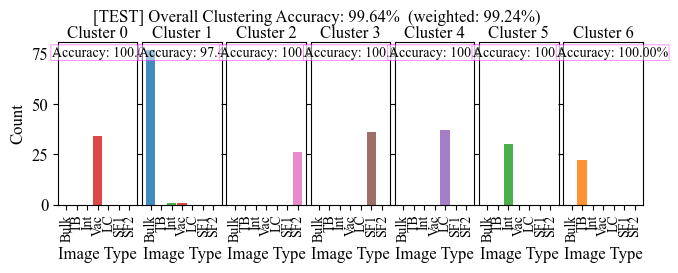

In [137]:
import matplotlib.pyplot as plt, os

figsize = (6.8, 2.5)
save_path = None 
dpi_export = 800; pad_inches = 0.03

markers = {
    'Bulk': 'o',   # circle
    'TB':   '^',   # triangle up
    'Int':  'v',   # triangle down
    'Vac':  's',   # square
    'LC':   'D',   # diamond
    'SF1':  'P',   # plus-filled
    'SF2':  'X'    # x-filled
}

colors = {
    'Bulk': '#1f77b4',  # blue
    'TB':   '#ff7f0e',  # orange
    'Int':  '#2ca02c',  # green
    'Vac':  '#d62728',  # red
    'LC':   '#9467bd',  # purple
    'SF1':  '#8c564b',  # brown
    'SF2':  '#e377c2'   # pink
}
hist_alpha = 0.85; wspace_value = 0.06
ylabel_fontsize = 12; xlabel_fontsize = 12; title_fontsize = 12; tick_fontsize = 10
accuracy_fontsize = 10; accuracy_x, accuracy_y = 0.62, 0.935

fig, axes = plt.subplots(1, best_num_clusters, figsize=figsize, sharey=True)
if best_num_clusters == 1: axes = [axes]

for c, ax in enumerate(axes):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty: ax.set_visible(False); continue
    type_counts = cdf["Type"].value_counts().reindex(colors.keys(), fill_value=0)
    ax.bar(type_counts.index, type_counts.values,
           color=[colors[t] for t in type_counts.index],
           alpha=hist_alpha, width=0.9)
    ax.set_title(f"Cluster {c}", fontsize=title_fontsize, pad=0.015)
    ax.set_xlabel("Image Type", fontsize=xlabel_fontsize)
    ax.tick_params(axis="x", rotation=90, labelsize=tick_fontsize)
    if c==0:
        ax.set_ylabel("Count", fontsize=ylabel_fontsize)
        ax.tick_params(axis="y", left=True, labelleft=True)
    else:
        ax.tick_params(axis="y", left=True, labelleft=False)
    acc = cluster_accuracies[c]
    ax.text(accuracy_x, accuracy_y, f"Accuracy: {acc:.2f}%",
            ha="center", va="center", transform=ax.transAxes, fontsize=accuracy_fontsize,
            bbox=dict(facecolor="white", edgecolor="magenta", boxstyle="round,pad=0.06", linewidth=0.6, alpha=0.5))

plt.subplots_adjust(left=0.12, right=0.98, bottom=0.2, top=0.85, wspace=wspace_value)
plt.suptitle(f"[TEST] Overall Clustering Accuracy: {overall_accuracy_mean:.2f}%  (weighted: {overall_accuracy_weighted:.2f}%)",
             fontsize=12, fontweight="normal")
if save_path:
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=dpi_export, bbox_inches='tight', pad_inches=pad_inches)
plt.show()


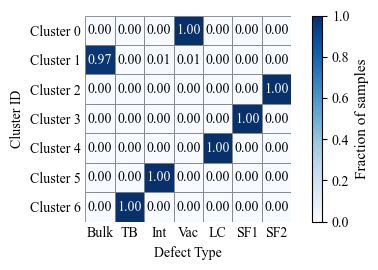

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

dpi_export = 800
pad_inches = 0.03

defect_types = ["Bulk", "TB", "Int", "Vac", "LC", "SF1", "SF2"]

K = best_num_clusters

comp = np.zeros((K, len(defect_types)))

for c in range(K):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty:
        continue
    total = len(cdf)
    for j, t in enumerate(defect_types):
        comp[c, j] = np.sum(cdf["Type"] == t) / total

fig, ax = plt.subplots(figsize=(5.8, 2.8))

norm = Normalize(vmin=0.0, vmax=1.0)
cmap = plt.cm.Blues

for i in range(K):
    for j in range(len(defect_types)):
        val = comp[i, j]
        ax.add_patch(
            plt.Rectangle(
                (j, K - 1 - i), 1, 1,
                facecolor=cmap(norm(val)),
                edgecolor="gray",
                linewidth=0.6
            )
        )
        ax.text(
            j + 0.5,
            K - 1 - i + 0.5,
            f"{val:.2f}",
            ha="center",
            va="center",
            fontsize=10,
            color="white" if val > 0.5 else "black"
        )

ax.set_xlim(0, len(defect_types))
ax.set_ylim(0, K)

ax.set_xticks(np.arange(len(defect_types)) + 0.5)
ax.set_xticklabels(defect_types)

ax.set_yticks(np.arange(K) + 0.5)
ax.set_yticklabels([f"Cluster {c}" for c in range(K)][::-1])

ax.set_xlabel("Defect Type")
ax.set_ylabel("Cluster ID")

ax.tick_params(length=0)
ax.set_aspect("equal")

for spine in ax.spines.values():
    spine.set_visible(False)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Fraction of samples", fontsize=11)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "cluster_defect_composition_heatmap.png"),
    dpi=dpi_export,
    bbox_inches="tight",
    pad_inches=pad_inches
)

plt.show()   # <-- SHOW THE PLOT


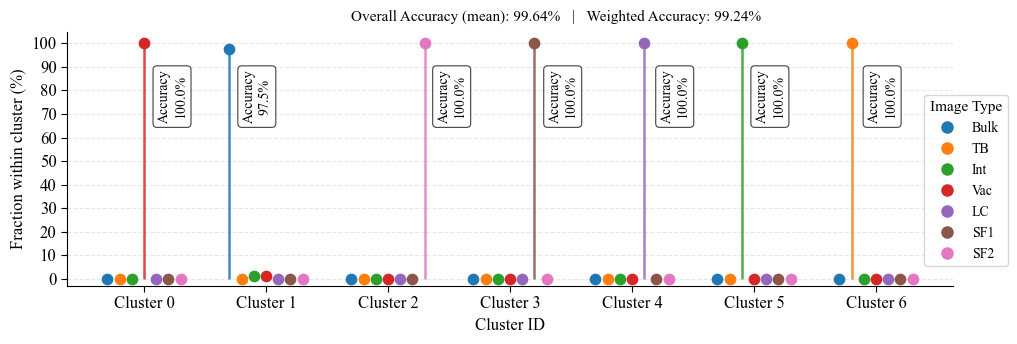

✔ Final grouped lollipop plot saved with full per-cluster control


In [168]:
# =========================================================
# GROUPED LOLLIPOP PLOT:
# Cluster × Image-Type Composition
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
assert "df_features" in globals(), "df_features not found"
assert "best_num_clusters" in globals(), "best_num_clusters not found"
assert "cluster_accuracies" in globals(), "cluster_accuracies not found"
assert "overall_accuracy_mean" in globals(), "overall_accuracy_mean not found"
assert "overall_accuracy_weighted" in globals(), "overall_accuracy_weighted not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

dpi_export = 800
pad_inches = 0.03

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

image_types = ["Bulk", "TB", "Int", "Vac", "LC", "SF1", "SF2"]
colors = {
    'Bulk': '#1f77b4',  # blue
    'TB':   '#ff7f0e',  # orange
    'Int':  '#2ca02c',  # green
    'Vac':  '#d62728',  # red
    'LC':   '#9467bd',  # purple
    'SF1':  '#8c564b',  # brown
    'SF2':  '#e377c2'   # pink
}

K = best_num_clusters
clusters = np.arange(K)

fractions = np.zeros((K, len(image_types)))

for c in range(K):
    cdf = df_features[df_features["Cluster"] == c]
    if cdf.empty:
        continue
    total = len(cdf)
    for j, t in enumerate(image_types):
        fractions[c, j] = np.sum(cdf["Type"] == t) / total

LINE_WIDTH   = 1.8
DOT_SIZE     = 55
GROUP_WIDTH  = 0.6

Y_MIN        = -3.0    
Y_MAX        = 105
Y_TICK_STEP  = 10

offsets = np.linspace(-GROUP_WIDTH/2, GROUP_WIDTH/2, len(image_types))


ANNOT_X_POS = [
    0.23,   # Cluster 0
    0.925,   # Cluster 1
    2.522,   # Cluster 2
    3.432,    # Cluster 3
    4.35,   # Cluster 4
    5.13,   # Cluster 5
    6.05    # Cluster 6
]

ANNOT_Y_POS = [
    66.0,   # Cluster 0
    66.0,   # Cluster 1
    66.0,   # Cluster 2
    66.0,    # Cluster 3
    66.0,   # Cluster 4
    66.0,   # Cluster 5
    66.0    # Cluster 6
]

ANNOT_ROTATION = 90
ANNOT_FONTSIZE = 10

BOX_PAD        = 0.28
BOX_EDGE_COLOR = "black"
BOX_FACE_COLOR = "white"
BOX_ALPHA      = 0.75
BOX_LINEWIDTH  = 0.8

assert len(ANNOT_X_POS) == K
assert len(ANNOT_Y_POS) == K

LEGEND_LOC   = "upper left"
LEGEND_BBOX  = (0.96, 0.78)
LEGEND_FRAME = True

fig, ax = plt.subplots(figsize=(12, 3.6))

# ---- Lollipops ----
for j, t in enumerate(image_types):
    x_pos = clusters + offsets[j]
    y_val = fractions[:, j] * 100.0

    for x, y in zip(x_pos, y_val):
        ax.vlines(
            x,
            ymin=0,
            ymax=y,
            color=colors[t],
            linewidth=LINE_WIDTH,
            alpha=0.85
        )
        ax.scatter(
            x,
            y,
            s=DOT_SIZE,
            color=colors[t],
            zorder=3
        )

ax.set_xticks(clusters)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Fraction within cluster (%)")

ax.set_ylim(Y_MIN, Y_MAX)
ax.set_yticks(np.arange(0, 101, Y_TICK_STEP))

ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.tick_params(length=4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for c in range(K):
    acc = cluster_accuracies[c]

    ax.text(
        ANNOT_X_POS[c],
        ANNOT_Y_POS[c],
        f"Accuracy\n{acc:.1f}%",
        rotation=ANNOT_ROTATION,
        ha="center",
        va="bottom",
        fontsize=ANNOT_FONTSIZE,
        bbox=dict(
            boxstyle=f"round,pad={BOX_PAD}",
            edgecolor=BOX_EDGE_COLOR,
            facecolor=BOX_FACE_COLOR,
            linewidth=BOX_LINEWIDTH,
            alpha=BOX_ALPHA
        ),
        zorder=5
    )

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        markerfacecolor=colors[t],
        markeredgecolor=colors[t],
        markersize=8,
        label=t
    )
    for t in image_types
]

ax.legend(
    handles=legend_handles,
    title="Image Type",
    loc=LEGEND_LOC,
    bbox_to_anchor=LEGEND_BBOX,
    frameon=LEGEND_FRAME,
    fontsize=10,
    title_fontsize=11
)

fig.text(
    0.47, 0.95,
    f"Overall Accuracy (mean): {overall_accuracy_mean:.2f}%   |   "
    f"Weighted Accuracy: {overall_accuracy_weighted:.2f}%",
    ha="center",
    va="top",
    fontsize=11
)

plt.tight_layout(rect=[0, 0, 0.86, 0.94])
plt.savefig(
    os.path.join(OUT_DIR, "cluster_image_type_lollipop_K_7.png"),
    dpi=dpi_export,
    bbox_inches="tight",
    pad_inches=pad_inches
)

plt.show()
plt.close()

print("✔ Final grouped lollipop plot saved with full per-cluster control")


# Defect Localization

In [188]:
BIG_IMAGE_PATH = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\Image-6_768x768 - Copy.tif"

img_big = Image.open(BIG_IMAGE_PATH).convert("L")
big_img = np.array(img_big, dtype=np.float32)

if big_img.max() > 1.0:
    big_img /= 255.0

H, W = big_img.shape
print("Big image shape:", big_img.shape)


Big image shape: (768, 768)


In [189]:
PATCH = 64

def extract_patches(img, patch=64):
    patches = []
    coords = []
    for i in range(0, img.shape[0], patch):
        for j in range(0, img.shape[1], patch):
            p = img[i:i+patch, j:j+patch]
            if p.shape == (patch, patch):
                patches.append(p)
                coords.append((i, j))
    return np.array(patches), coords

patches, coords = extract_patches(big_img, PATCH)
print("Number of patches:", len(patches))


Number of patches: 144


In [190]:
patches = np.expand_dims(patches, axis=-1)  # (N,64,64,1)

def make_infer_ds(images_64, batch=32):
    ds = tf.data.Dataset.from_tensor_slices(images_64)
    ds = ds.map(lambda x: preprocess_for_vgg(x),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

infer_ds = make_infer_ds(patches)


In [191]:
embeddings = np.vstack([
    embedder.predict(xb, verbose=0) for xb in infer_ds
]).astype(np.float32)

print("Embedding shape:", embeddings.shape)


Embedding shape: (144, 512)


In [193]:
required = ["scaler", "pca_model", "km", "embeddings"]
for r in required:
    assert r in globals(), f"{r} not found — run clustering cell first"

Z  = scaler.transform(embeddings)      # scale using DEV scaler
Zp = pca_model.transform(Z)            # PCA using selected best_p

cluster_ids = km.predict(Zp)            # KMeans using selected best_k

print("Assigned cluster IDs:", cluster_ids)
print("Number of patches:", len(cluster_ids))
print("Unique clusters:", sorted(set(cluster_ids)))


Assigned cluster IDs: [1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2
 1 1 1 1 3 1 1 1 1 1 1 1 2 2 2 1 3 1 1 1 1 1 1 1 1 1 1 1 4 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 6 6 6 1 1 1 1 1 1 1 5 1]
Number of patches: 144
Unique clusters: [0, 1, 2, 3, 4, 5, 6]


In [194]:
# =========================================================
# Reconstruct spatial cluster map (64×64 tiles)
# =========================================================

PATCH = 64
GRID  = 768 // PATCH

cluster_map = np.zeros((GRID, GRID), dtype=int)

for idx, (i, j) in enumerate(coords):
    r = i // PATCH
    c = j // PATCH
    cluster_map[r, c] = cluster_ids[idx]

print("Cluster map shape:", cluster_map.shape)

Cluster map shape: (12, 12)


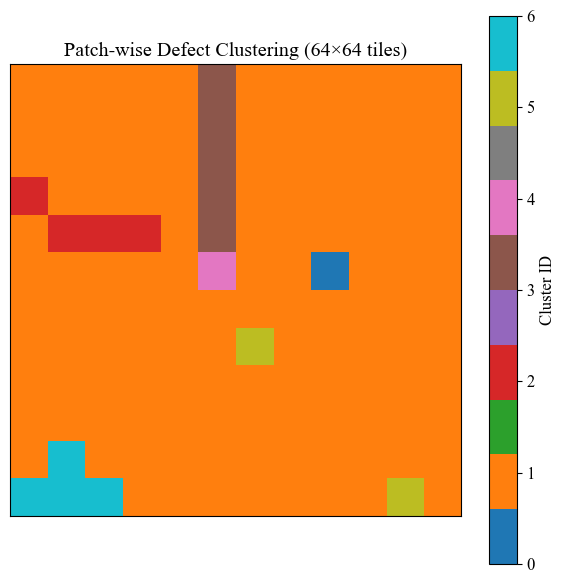

In [195]:
# =========================================================
# Visualize patch-wise clustering
# =========================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.figure(figsize=(6, 6))
im = plt.imshow(cluster_map, cmap="tab10", interpolation="nearest")
plt.xticks([])
plt.yticks([])
plt.title("Patch-wise Defect Clustering (64×64 tiles)")
plt.colorbar(im, label="Cluster ID")

plt.tight_layout()
plt.show()


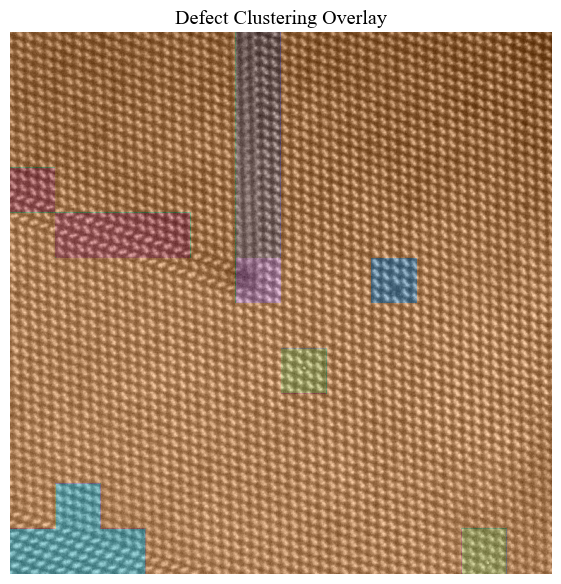

In [196]:
# =========================================================
# Overlay cluster map on original image
# =========================================================

plt.figure(figsize=(6, 6))
plt.imshow(big_img, cmap="gray")

overlay = cluster_map.repeat(PATCH, axis=0).repeat(PATCH, axis=1)
plt.imshow(overlay, cmap="tab10", alpha=0.35)

plt.axis("off")
plt.title("Defect Clustering Overlay")
plt.tight_layout()
plt.show()


# Supervised prediction on tiles (7-class labeling)

In [197]:
# =========================================================
# Supervised tile-level prediction (4 defect types)
# =========================================================

import numpy as np
import tensorflow as tf

infer_ds_tiles = make_infer_ds(patches, batch=32)

probs = np.vstack([
    clf.predict(xb, verbose=0) for xb in infer_ds_tiles
])

pred_class_ids = np.argmax(probs, axis=1)
pred_conf      = np.max(probs, axis=1)

pred_labels = le.inverse_transform(pred_class_ids)

print("Supervised labels (first 10):")
for i in range(10):
    print(pred_labels[i], f"(conf={pred_conf[i]:.2f})")


Supervised labels (first 10):
Bulk (conf=0.86)
Bulk (conf=0.93)
Bulk (conf=0.96)
Bulk (conf=0.96)
Bulk (conf=0.91)
SF1 (conf=0.99)
Bulk (conf=0.95)
Bulk (conf=0.98)
Bulk (conf=0.96)
Bulk (conf=0.99)


In [198]:
required = ["scaler", "pca_model", "km", "embeddings", "best_k"]
for r in required:
    assert r in globals(), f"{r} not found — run clustering cell first"


Z  = scaler.transform(embeddings)   # scale using DEV scaler
Zp = pca_model.transform(Z)         # PCA using selected best_p

cluster_ids = km.predict(Zp)

print("Cluster IDs (first 10):", cluster_ids[:10])
print("Total samples:", len(cluster_ids))
print("Unique clusters:", np.unique(cluster_ids))


Cluster IDs (first 10): [1 1 1 1 1 3 1 1 1 1]
Total samples: 144
Unique clusters: [0 1 2 3 4 5 6]


In [199]:
tile_rows = []
for idx, (i, j) in enumerate(coords):
    tile_rows.append({
        "tile_row": i // PATCH,
        "tile_col": j // PATCH,
        "x_px": j,
        "y_px": i,
        "Supervised_Label": pred_labels[idx],
        "Supervised_Confidence": pred_conf[idx],
        "Cluster_ID": cluster_ids[idx]
    })

df_tiles = pd.DataFrame(tile_rows)

print(df_tiles.head())


   tile_row  tile_col  x_px  y_px Supervised_Label  Supervised_Confidence  \
0         0         0     0     0             Bulk               0.860281   
1         0         1    64     0             Bulk               0.934298   
2         0         2   128     0             Bulk               0.963779   
3         0         3   192     0             Bulk               0.957463   
4         0         4   256     0             Bulk               0.907021   

   Cluster_ID  
0           1  
1           1  
2           1  
3           1  
4           1  


## Visualization: Supervised defect-type map

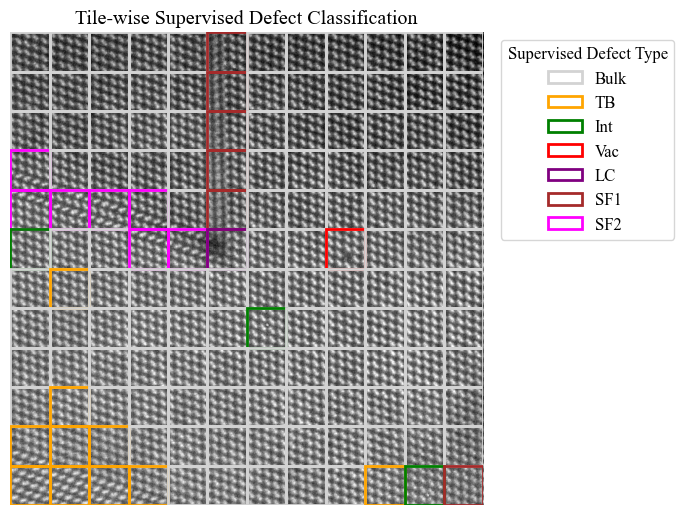

In [200]:
# =========================================================
# Visualization: Supervised defect-type map 
# =========================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import matplotlib.cm as cm

label_color_map = {
    "Bulk": "lightgray",
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "purple",
    "SF1":  "brown",
    "SF2":  "magenta"
}

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    color = label_color_map[label]

    rect = Rectangle(
        (j, i),
        PATCH, PATCH,
        linewidth=2.0,
        edgecolor=color,
        facecolor="none"
    )
    ax.add_patch(rect)

# Legend
legend_handles = [
    Patch(facecolor="none", edgecolor=c, linewidth=2, label=l)
    for l, c in label_color_map.items()
]

ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Supervised Defect Type"
)

ax.set_title("Tile-wise Supervised Defect Classification")
plt.tight_layout()
plt.show()

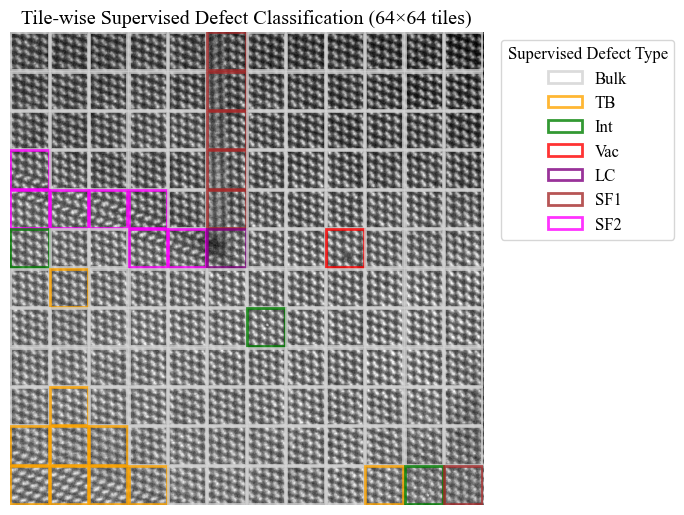

In [201]:
# =========================================================
# Visualization: Supervised defect-type map 
# =========================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch


TILE_SIZE      = 62    
BOUNDARY_ALPHA = 0.8   
BOUNDARY_WIDTH = 2    

# -------------------------
# Color mapping
# -------------------------
label_color_map = {
    "Bulk": "lightgray",
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "purple",
    "SF1":  "brown",
    "SF2":  "magenta"
}

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    color = label_color_map[label]

    rect = Rectangle(
        (j, i),                  
        TILE_SIZE, TILE_SIZE,    
        linewidth=BOUNDARY_WIDTH,
        edgecolor=color,
        facecolor="none",
        alpha=BOUNDARY_ALPHA    
    )
    ax.add_patch(rect)

# -------------------------
# Legend (outside)
# -------------------------
legend_handles = [
    Patch(
        facecolor="none",
        edgecolor=color,
        linewidth=BOUNDARY_WIDTH,
        alpha=BOUNDARY_ALPHA,
        label=label
    )
    for label, color in label_color_map.items()
]

ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Supervised Defect Type",
    frameon=True
)

ax.set_title("Tile-wise Supervised Defect Classification (64×64 tiles)")
plt.tight_layout()
plt.show()


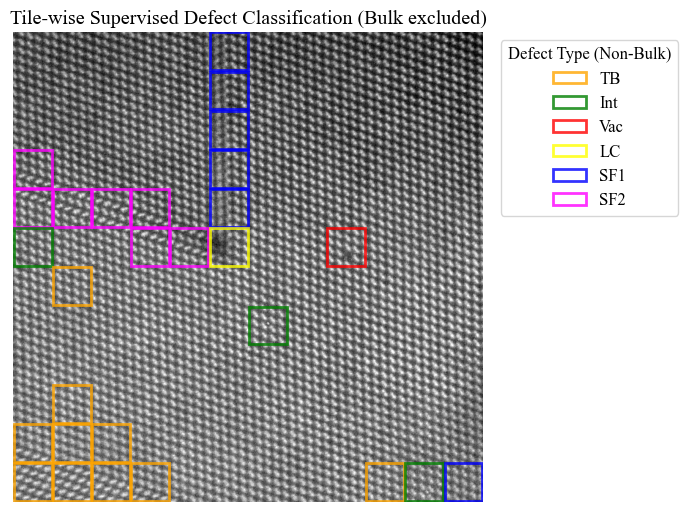

In [204]:
# =========================================================
# Visualization: Supervised defect-type map 
# EXCLUDING Bulk tiles
# =========================================================

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

# -------------------------
# USER CONTROLS
# -------------------------
TILE_SIZE      = 62     
BOUNDARY_ALPHA = 0.8
BOUNDARY_WIDTH = 2

# -------------------------
# Color mapping
# -------------------------
label_color_map = {
    "Bulk": "lightgray",
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "yellow",
    "SF1":  "blue",
    "SF2":  "magenta"
}

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]

    # >>> SKIP BULK TILES <<<
    if label == "Bulk":
        continue

    color = label_color_map[label]

    rect = Rectangle(
        (j, i),              
        TILE_SIZE, TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=color,
        facecolor="none",
        alpha=BOUNDARY_ALPHA
    )
    ax.add_patch(rect)

# -------------------------
# Legend (exclude Bulk)
# -------------------------
legend_handles = [
    Patch(
        facecolor="none",
        edgecolor=color,
        linewidth=BOUNDARY_WIDTH,
        alpha=BOUNDARY_ALPHA,
        label=label
    )
    for label, color in label_color_map.items()
    if label != "Bulk"
]

ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Defect Type (Non-Bulk)",
    frameon=True
)

ax.set_title("Tile-wise Supervised Defect Classification (Bulk excluded)")
plt.tight_layout()
plt.show()


In [205]:
# =========================================================
# Compute tile-center (x, y) coordinates for defect tiles
# =========================================================

import pandas as pd

TILE_SIZE = 64

tile_centers = []

print("\nDefect tile center coordinates (in pixels):\n")

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]

    # Skip Bulk tiles
    if label == "Bulk":
        continue

    x_center = j + TILE_SIZE // 2
    y_center = i + TILE_SIZE // 2

    tile_centers.append({
        "Tile_Row": i // TILE_SIZE,
        "Tile_Col": j // TILE_SIZE,
        "x_px": x_center,
        "y_px": y_center,
        "Defect_Type": label,
        "Confidence": pred_conf[idx],
        "Cluster_ID": cluster_ids[idx]
    })

    print(
        f"Tile ({i//TILE_SIZE:2d}, {j//TILE_SIZE:2d})  →  "
        f"x = {x_center:4d}, y = {y_center:4d}  |  "
        f"{label:>4s}  (conf={pred_conf[idx]:.2f}), "
        f"Cluster {cluster_ids[idx]}"
    )

df_tile_centers = pd.DataFrame(tile_centers)



Defect tile center coordinates (in pixels):

Tile ( 0,  5)  →  x =  352, y =   32  |   SF1  (conf=0.99), Cluster 3
Tile ( 1,  5)  →  x =  352, y =   96  |   SF1  (conf=0.93), Cluster 3
Tile ( 2,  5)  →  x =  352, y =  160  |   SF1  (conf=0.84), Cluster 3
Tile ( 3,  0)  →  x =   32, y =  224  |   SF2  (conf=0.95), Cluster 2
Tile ( 3,  5)  →  x =  352, y =  224  |   SF1  (conf=0.51), Cluster 3
Tile ( 4,  0)  →  x =   32, y =  288  |   SF2  (conf=0.40), Cluster 1
Tile ( 4,  1)  →  x =   96, y =  288  |   SF2  (conf=0.92), Cluster 2
Tile ( 4,  2)  →  x =  160, y =  288  |   SF2  (conf=0.85), Cluster 2
Tile ( 4,  3)  →  x =  224, y =  288  |   SF2  (conf=0.63), Cluster 2
Tile ( 4,  5)  →  x =  352, y =  288  |   SF1  (conf=0.82), Cluster 3
Tile ( 5,  0)  →  x =   32, y =  352  |   Int  (conf=0.33), Cluster 1
Tile ( 5,  3)  →  x =  224, y =  352  |   SF2  (conf=0.47), Cluster 1
Tile ( 5,  4)  →  x =  288, y =  352  |   SF2  (conf=0.77), Cluster 1
Tile ( 5,  5)  →  x =  352, y =  352  |    L

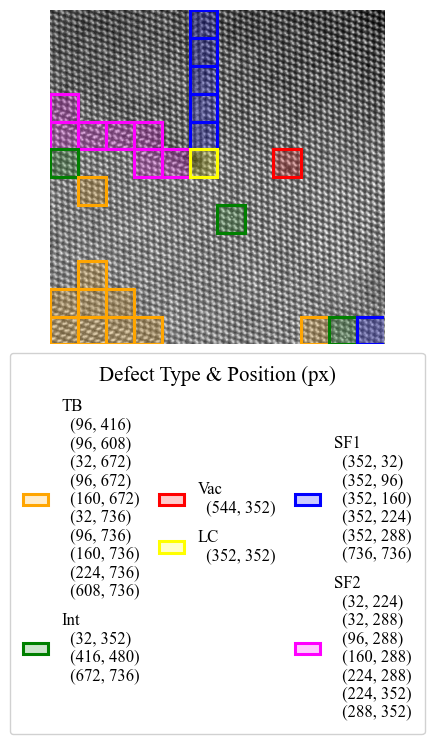

✔ Defect map saved (positions embedded inside legend box)
📁 Location: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs


In [209]:
# =========================================================
# Supervised Defect Map
# Legend includes defect types + (x, y) positions INSIDE box
# =========================================================

import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import to_rgba
required = ["big_img", "coords", "pred_labels", "pred_conf", "cluster_ids"]
for r in required:
    assert r in globals(), f"{r} not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"

TILE_SIZE        = 64
BOUNDARY_WIDTH = 2.2
EDGE_ALPHA     = 1.0     
FILL_ALPHA     = 0.2    
FILL_TILES       = True
FILL_ALPHA       = 0.2

TITLE_FONTSIZE   = 12
LEGEND_FONTSIZE  = 12
LEGEND_TITLE_FS  = 15

# -------------------------
# COLOR MAP (Bulk excluded)
# -------------------------
label_color_map = {
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "yellow",
    "SF1":  "blue",
    "SF2":  "magenta"
}

# -------------------------
# COLLECT TILE CENTERS BY TYPE
# -------------------------
positions_by_type = {k: [] for k in label_color_map.keys()}

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    if label == "Bulk":
        continue

    x_center = j + TILE_SIZE // 2
    y_center = i + TILE_SIZE // 2

    positions_by_type[label].append((x_center, y_center))

# -------------------------
# BUILD LEGEND LABELS
# -------------------------
from matplotlib.colors import to_rgba

legend_handles = []

for label, color in label_color_map.items():
    pos_list = positions_by_type[label]

    if len(pos_list) == 0:
        pos_text = "  None"
    else:
        pos_text = "\n".join([f"  ({x}, {y})" for x, y in pos_list])

    legend_label = f"{label}\n{pos_text}"

    # --- SOLID EDGE + TRANSPARENT FILL ---
    edge_rgba = to_rgba(color, 1.0)               
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    legend_handles.append(
        Patch(
            edgecolor=edge_rgba,
            facecolor=face_rgba,
            linewidth=BOUNDARY_WIDTH,
            label=legend_label
        )
    )
# -------------------------
# PLOT IMAGE + BOXES
# -------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    if label == "Bulk":
        continue

    color = label_color_map[label]

    edge_rgba = to_rgba(color, EDGE_ALPHA)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    rect = Rectangle(
        (j, i),
        TILE_SIZE,
        TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=edge_rgba,   # <<< SOLID, SHARP EDGE
        facecolor=face_rgba   # <<< TRANSPARENT FILL
    )

    ax.add_patch(rect)

legend = ax.legend(
    handles=legend_handles,
    ncol=3,                              # <<< 3 columns
    loc="upper center",
    bbox_to_anchor=(0.5, 0),         # <<< below the axes
    fontsize=LEGEND_FONTSIZE,
    title="Defect Type & Position (px)",
    title_fontsize=LEGEND_TITLE_FS,
    frameon=True,
    handlelength=1.5,
    handletextpad=0.8,
    borderpad=0.8,
    labelspacing=0.8,
    columnspacing=1.2                  
)

legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "defect_map_with_positions_in_legnd.png"),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()

print("✔ Defect map saved (positions embedded inside legend box)")
print(f"📁 Location: {OUT_DIR}")


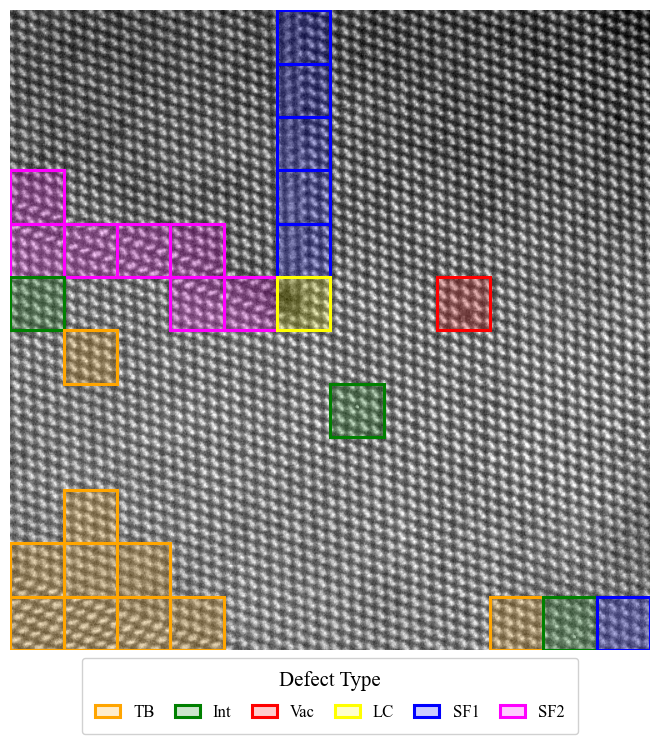

✔ Defect map saved (legend = defect types only)
📁 Location: C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs


In [215]:
# =========================================================
# Supervised Defect Map
# =========================================================

import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import to_rgba
required = ["big_img", "coords", "pred_labels", "pred_conf", "cluster_ids"]
for r in required:
    assert r in globals(), f"{r} not found"

# -------------------------
# OUTPUT DIRECTORY
# -------------------------
OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"

TILE_SIZE        = 64
BOUNDARY_WIDTH   = 2.2
EDGE_ALPHA       = 1.0    
FILL_ALPHA       = 0.2
FILL_TILES       = True
TITLE_FONTSIZE   = 12
LEGEND_FONTSIZE  = 12
LEGEND_TITLE_FS  = 15

# -------------------------
# COLOR MAP (Bulk excluded)
# -------------------------
label_color_map = {
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "yellow",
    "SF1":  "blue",
    "SF2":  "magenta"
}

legend_handles = []

for label, color in label_color_map.items():
    edge_rgba = to_rgba(color, 1.0)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    legend_handles.append(
        Patch(
            edgecolor=edge_rgba,
            facecolor=face_rgba,
            linewidth=BOUNDARY_WIDTH,
            label=label
        )
    )

fig, ax = plt.subplots(figsize=(7.6, 7.6))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    if label == "Bulk":
        continue

    color = label_color_map[label]

    edge_rgba = to_rgba(color, EDGE_ALPHA)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    rect = Rectangle(
        (j, i),
        TILE_SIZE,
        TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=edge_rgba,
        facecolor=face_rgba
    )
    ax.add_patch(rect)

legend = ax.legend(
    handles=legend_handles,
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    fontsize=LEGEND_FONTSIZE,
    title="Defect Type",
    title_fontsize=LEGEND_TITLE_FS,
    frameon=True,
    handlelength=1.5,
    handletextpad=0.8,
    borderpad=0.8,
    labelspacing=0.8,
    columnspacing=1.2
)

legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "defect_map_legend_types_only.png"),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()

print("✔ Defect map saved (legend = defect types only)")
print(f"📁 Location: {OUT_DIR}")


# Confidence score thresholding

In [ ]:
required = ["big_img", "coords", "pred_labels", "pred_conf", "cluster_ids"]
for r in required:
    assert r in globals(), f"{r} not found"

OUT_DIR = r"C:\Users\rayyub2\Desktop\Ayyubi\Hackathon\VGG_16\CdTe\CdTe_Figs"
os.makedirs(OUT_DIR, exist_ok=True)

DPI = 600
PAD = 0.03

plt.rcParams["font.family"] = "Times New Roman"

TILE_SIZE        = 64
BOUNDARY_WIDTH   = 2.2
EDGE_ALPHA       = 1.0    
FILL_ALPHA       = 0.2
FILL_TILES       = True

TITLE_FONTSIZE   = 12
LEGEND_FONTSIZE  = 12
LEGEND_TITLE_FS  = 15

label_color_map = {
    "TB":   "orange",
    "Int":  "green",
    "Vac":  "red",
    "LC":   "yellow",
    "SF1":  "blue",
    "SF2":  "magenta"
}

legend_handles = []

for label, color in label_color_map.items():
    edge_rgba = to_rgba(color, 1.0)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    legend_handles.append(
        Patch(
            edgecolor=edge_rgba,
            facecolor=face_rgba,
            linewidth=BOUNDARY_WIDTH,
            label=label
        )
    )

fig, ax = plt.subplots(figsize=(7.6, 7.6))
ax.imshow(big_img, cmap="gray")
ax.set_axis_off()


CONF_THRESHOLD = 0.4   # <<< confidence score cutoff

for idx, (i, j) in enumerate(coords):
    label = pred_labels[idx]
    conf  = pred_conf[idx]

    # Skip Bulk tiles
    if label == "Bulk":
        continue

    # >>> SKIP LOW-CONFIDENCE PREDICTIONS <<<
    if conf < CONF_THRESHOLD:
        continue

    color = label_color_map[label]

    edge_rgba = to_rgba(color, EDGE_ALPHA)
    face_rgba = to_rgba(color, FILL_ALPHA) if FILL_TILES else "none"

    rect = Rectangle(
        (j, i),
        TILE_SIZE,
        TILE_SIZE,
        linewidth=BOUNDARY_WIDTH,
        edgecolor=edge_rgba,
        facecolor=face_rgba
    )
    ax.add_patch(rect)

legend = ax.legend(
    handles=legend_handles,
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    fontsize=LEGEND_FONTSIZE,
    title="Defect Type",
    title_fontsize=LEGEND_TITLE_FS,
    frameon=True,
    handlelength=1.5,
    handletextpad=0.8,
    borderpad=0.8,
    labelspacing=0.8,
    columnspacing=1.2
)

legend.get_frame().set_alpha(0.9)

# -------------------------
# SAVE + SHOW
# -------------------------
plt.tight_layout()
plt.savefig(
    os.path.join(OUT_DIR, "defect_map_Conf_score.png"),
    dpi=DPI,
    bbox_inches="tight",
    pad_inches=PAD
)

plt.show()
plt.close()

print("✔ Defect map saved (legend = defect types only)")
print(f"📁 Location: {OUT_DIR}")
